In [1]:
import fairbench as fb
import numpy as np

# Load data

In [2]:
train = fb.read_csv("adult/adult.data", header=None, skipinitialspace=True)
test = fb.read_csv("adult/adult.test", header=None, skipinitialspace=True, skiprows=[0])
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
numeric = [0, 4, 11, 12]
categorical = [1, 3, 5, 6]

x_train = fb.features(train, numeric, categorical)
y_train = (train[14]==">50K").values

x_test = fb.features(test, numeric, categorical)
y_test = (test[14]==">50K.").values

# Make AI predictions

In [4]:
import sklearn
from sklearn.linear_model import LogisticRegression

x_train_scaled = sklearn.preprocessing.MinMaxScaler().fit_transform(x_train)
x_test_scaled = sklearn.preprocessing.MinMaxScaler().fit_transform(x_test)

classifier = LogisticRegression(max_iter=1000)
classifier = classifier.fit(x_train_scaled, y_train)
predictions = classifier.predict(x_test_scaled)

# Evaluate fairness

In [5]:
test[9]

0          Male
1          Male
2          Male
3          Male
4        Female
          ...  
16276    Female
16277      Male
16278      Male
16279      Male
16280      Male
Name: 9, Length: 16281, dtype: object

In [6]:
sensitive = fb.Fork(fb.categories@test[9])
sensitive

Male,[1 1 1 ... 1 1 1]
Female,[0 0 0 ... 0 0 0]


In [7]:
sensitive = fb.Fork(gender=fb.categories@test[9], race=fb.categories@test[8])
sensitive

genderMale,[1 1 1 ... 1 1 1]
genderFemale,[0 0 0 ... 0 0 0]
raceAsian-Pac-Islander,[0 0 0 ... 0 1 0]
raceAmer-Indian-Eskimo,[0 0 0 ... 0 0 0]
raceWhite,[0 1 1 ... 1 0 1]
raceBlack,[1 0 0 ... 0 0 0]
raceOther,[0 0 0 ... 0 0 0]


In [8]:
report = fb.multireport(predictions=predictions, labels=y_test, sensitive=sensitive)
report

accuracy,0.7985267034990792
pr,0.053864600627190555
tpr,0.6141732283464567
tnr,0.8344861660079052
accuracy,0.8711638679147732
pr,0.20199225235196458
tpr,0.7258410880458125
tnr,0.8977143001165311
accuracy,0.11809384621499575
pr,0.2128020660394761
tpr,0.23198061780738943


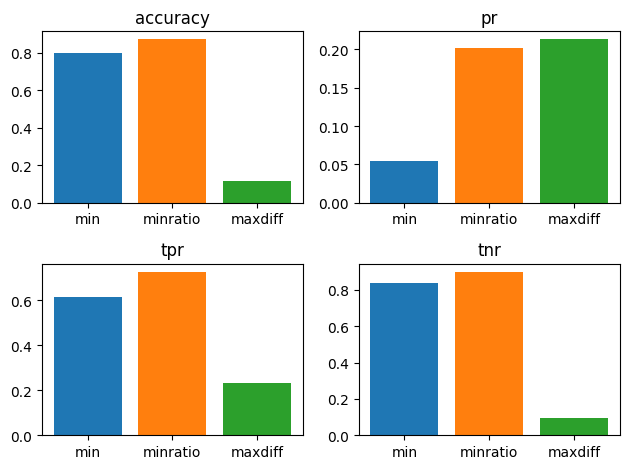

In [9]:
fb.visualize(report)

In [10]:
print(fb.accuracy(predictions=predictions, labels=y_test))
report.min.accuracy  # average across individual attribute value assessments

0.837847798046803


0.7985267034990792

In [11]:
report.min.pr.explain  # this is also a report

raceAmer-Indian-Eskimo,0.08176100628930817
genderFemale,0.053864600627190555
genderMale,0.25451197053407
raceWhite,0.19898178689229887
raceBlack,0.08135810377962845
raceOther,0.0962962962962963
raceAsian-Pac-Islander,0.26666666666666666


# Intersectional fairness

In [12]:
sensitive_intersections = fb.Fork(gender=fb.categories@test[9], 
                                  race=fb.categories@test[8], 
                                  marital=fb.categories@test[5]).intersectional()  # empty intersections are ignored
sensitive_intersections

maritalNever-married,[1 0 0 ... 0 0 0]
maritalWidowed,[0 0 0 ... 0 0 0]
maritalMarried-spouse-absent,[0 0 0 ... 0 0 0]
maritalMarried-civ-spouse,[0 1 1 ... 1 0 1]
maritalMarried-AF-spouse,[0 0 0 ... 0 0 0]
maritalSeparated,[0 0 0 ... 0 0 0]
maritalDivorced,[0 0 0 ... 0 1 0]
raceOther,[0 0 0 ... 0 0 0]
raceOther&maritalNever-married,[0 0 0 ... 0 0 0]
raceOther&maritalWidowed,[0 0 0 ... 0 0 0]
raceOther&maritalMarried-spouse-absent,[0 0 0 ... 0 0 0]


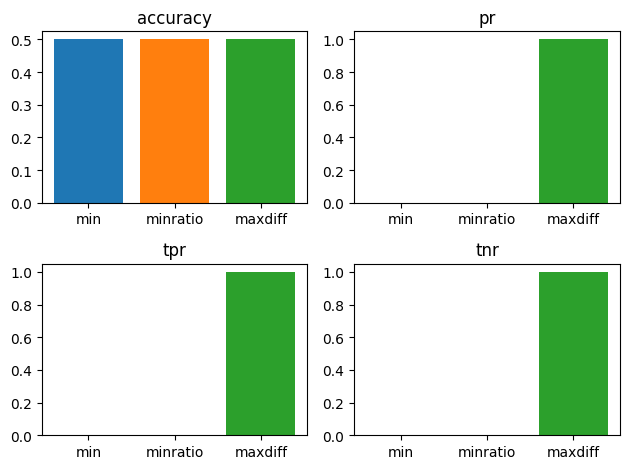

In [13]:
intersectional_report = fb.multireport(predictions=predictions, labels=y_test, sensitive=sensitive_intersections)
fb.visualize(intersectional_report)

In [14]:
intersectional_report.min.pr.explain  #zero min ratio due to the complete absense of extremely small intersections from positive predictions

genderFemale&raceBlack&maritalNever-married,0.0
raceAmer-Indian-Eskimo&maritalMarried-spouse-absent,0.0
genderMale&raceBlack&maritalNever-married,0.0
raceWhite&maritalSeparated,0.014164305949008499
genderMale&raceAmer-Indian-Eskimo&maritalWidowed,0.0
genderFemale&maritalSeparated,0.0033333333333333335
genderFemale&raceAmer-Indian-Eskimo&maritalNever-married,0.0
genderMale&raceWhite&maritalWidowed,0.09090909090909091
genderFemale&raceWhite&maritalDivorced,0.00975177304964539
raceBlack&maritalMarried-civ-spouse,0.2863849765258216
genderFemale&raceWhite&maritalNever-married,0.00255885363357216


In [15]:
bayesian = fb.reduce(
    fb.surrogate_positives(predictions, sensitive),
    fb.min,
    fb.ratio,
    name=None,
)
all_sensitive = fb.Fork(fb.categories@test[9] & fb.categories@test[8] & fb.categories@test[5])  # all combinations
all_report = fb.multireport(predictions=predictions, labels=y_test, sensitive=all_sensitive)

fb.Fork(prule={"bayesian": bayesian, 
               "empirical": all_report.minratio["pr"]  # this will be zero for empty intersections
              })

bayesian,0.023732426041449543
empirical,0.0
